In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA, convert_image
from parameters import *
from models import *

In [3]:
print(device)

cuda


In [4]:
scaling_factor = 2
crop_size = 96*scaling_factor
large_kernel_size = 9
small_kernel_size = 3
n_channels = 64
n_blocks = 16
lr_img_type = 'imagenet-norm'#'[0, 1]'#'gta-small-norm'#
hr_img_type = 'imagenet-norm'#'[0, 1]'#'[-1, 1]'

batch_size = 8
epochs = 5
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
criterion = nn.MSELoss().to(device)
#checkpoint = 'checkpoint_srresnet.pth.tar'
checkpoint = None
if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
else:
    model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
    start_epoch = 0



truncated_vgg19 = TruncatedVGG19(i=5, j=4).to(device)
truncated_vgg19.eval()

/home/deniz/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/deniz/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/deniz/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:39<00:00, 5.75MB/s] 


TruncatedVGG19(
  (truncated_vgg19): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), s

In [6]:
losses = []

for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        convert_image(sr_imgs, source='[-1, 1]', target='imagenet-norm')

        sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
        hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()

        loss = criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)

    torch.save({'epoch': epoch+start_epoch,
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_srresnet_vgg19.pth.tar')

EPOCH 1


Epoch 1/5:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/313 [00:02<?, ?it/s]


KeyboardInterrupt: 

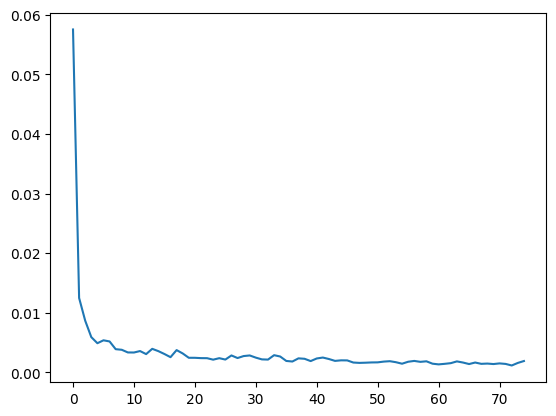

In [25]:
plt.plot(losses)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


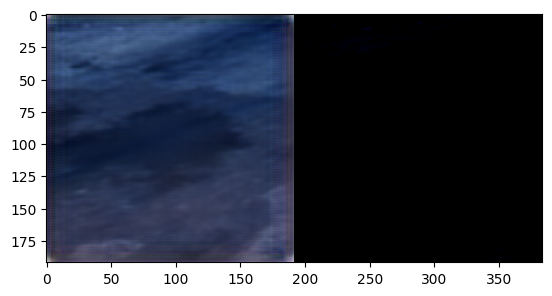

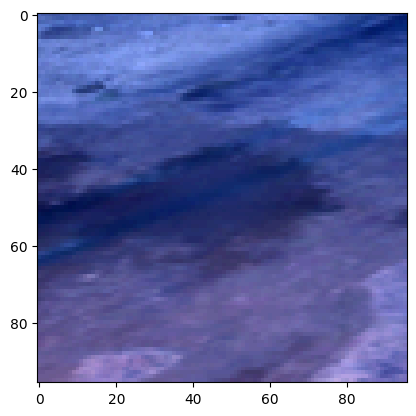

In [7]:
from srresnet import _NetD

checkpoint = torch.load('checkpoint_srresnet_.pth.tar')
model = checkpoint['model']
#model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor)

with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        sr_img = model(lr_img.unsqueeze(0)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        sr_img = (sr_img+1)/2
        sr_img = (sr_img - np.min(sr_img)) / (np.max(sr_img) - np.min(sr_img))
        plt.imshow(np.concatenate([sr_img, ((hr_img+1)/2).permute(1, 2, 0).numpy()], axis=1))
        plt.show()
        plt.imshow(((lr_img-torch.min(lr_img))/(torch.max(lr_img)-torch.min(lr_img))).permute(1, 2, 0).numpy())
        plt.show()
        break